## Guest Journey Path Analysis

### Import Required Libraries

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

### Data Reading and Preparation

In [2]:
from data_preparation import prepare_data

# survey responses data
df_path = '../data/survey_responses/cleaned_survey_responses.csv'
data = prepare_data(df_path)
print(data.head())

# rides data
df1 = pd.read_csv('../data/uss_attraction_details/attractions.csv')
df2 = pd.read_csv('../data/uss_attraction_details/rides.csv')
intensity = pd.DataFrame({'intensity':['medium', 'medium', 'high', 'high', 'low', 'medium', 'medium', 'low', 'medium', 'medium', 'low', 'medium', 'high', 'medium', 'medium', 'low', 'high', 'low']})
rides = pd.concat([df1, df2, intensity], axis=1, join='inner')
rides = rides[['Zone', 'ride', 'type', 'environment', 'intensity']]
print(rides.head())

    response_id            timestamp  visited_US            visit_freq  \
93           93  22/02/2025 12:23:46        True      When on vacation   
94           94  22/02/2025 18:44:37        True      When on vacation   
96           96  22/02/2025 18:58:00        True       Once every year   
98           98  22/02/2025 19:32:46        True       Once every year   
99           99  22/02/2025 19:33:14        True  < Once every 3 years   

                age  gender     monthly_income     nationality  \
93  19-25 years old    Male          No income  singaporean/pr   
94     55 and above  Others  $20,000 and above         russian   
96  15-18 years old  Female          No income  singaporean/pr   
98  19-25 years old  Female        Below $2000  singaporean/pr   
99  19-25 years old  Female        Below $2000  singaporean/pr   

                                companion ride_pref  ...  \
93                                Friends    medium  ...   
94                                 Fam

### USS Zone Analysis

#### Distribution of Attraction Types in USS

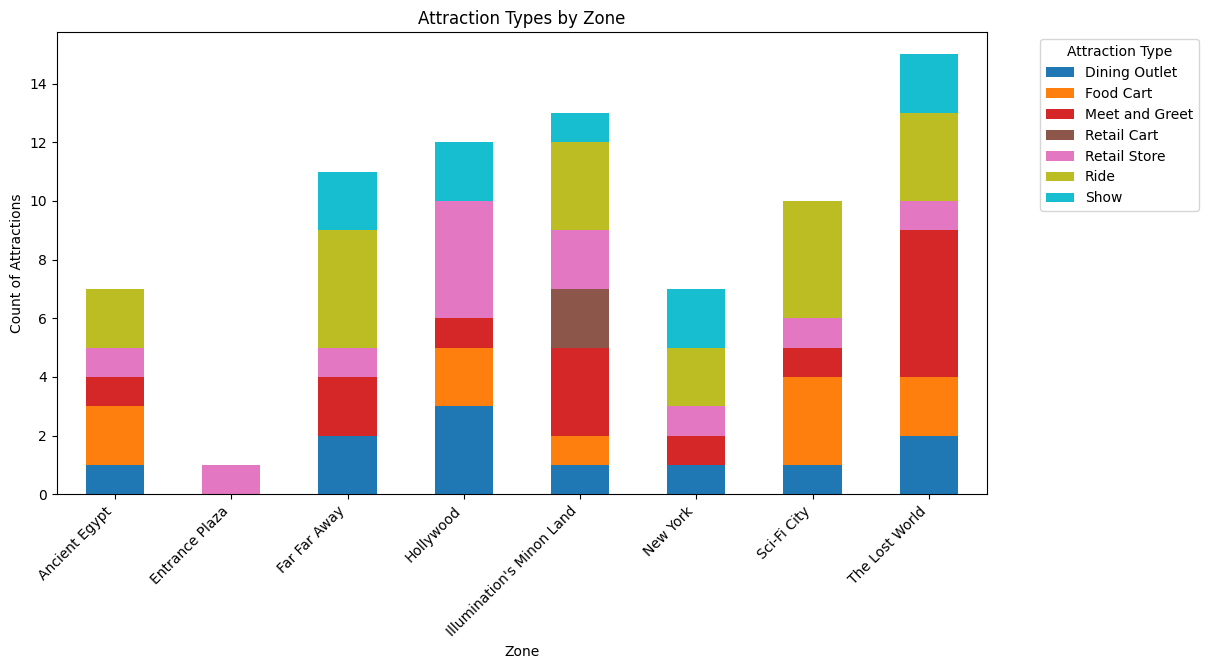

In [3]:
df_pivot = pd.DataFrame(df1.groupby(['Zone', 'Type']).agg('count').unstack())

# Plot
df_pivot.plot(kind="bar", stacked=True, figsize=(12, 6), colormap="tab10")
plt.title("Attraction Types by Zone")
plt.xlabel("Zone")
plt.ylabel("Count of Attractions")
plt.xticks(rotation=45, ha="right")
plt.legend(title="Attraction Type", labels=['Dining Outlet', 'Food Cart', 'Meet and Greet', 'Retail Cart', 'Retail Store', 'Ride', 'Show'], bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

#### Categorising Zones by Ride Intensity

As we aim to look any possible correlation of guests' ride preferences with the order they traverse through the park, we segment the zones by their ride intensities based on the highest number of rides of a certain intensity, with priority towards rides of higher intensity. [I DONT KNOW HOW TO JUSTFIFY THIS HELP] IT JUST MAKES SENSE

In [4]:
zone_intensity = rides[['Zone', 'intensity']]
intensity_order = {"high": 3, "medium": 2, "low": 1} #prioritise upper bound as tiebreaker
zone_intensity = zone_intensity.groupby('Zone')['intensity'].agg(lambda x: x.mode()[x.mode().map(intensity_order).argmax()])
print(pd.DataFrame(zone_intensity))

                          intensity
Zone                               
Ancient Egypt                  high
Far Far Away                 medium
Illumination's Minon Land       low
New York                     medium
Sci-Fi City                    high
The Lost World               medium


### Guest Analysis

#### Segmenting Guests by Ride Intensity Preferences

In [5]:
print(data.groupby('ride_pref').agg('count')['response_id'])

ride_pref
high        16
low          4
medium      12
no_rides     1
Name: response_id, dtype: int64


Due to the low count of responses for those with low ride preferences and those who do not take rides at all, we will merge these responses together as `low_guests`. `low_guests` and `med_guests` will be merged together too as `other_guests` for selective areas of analysis where appropriate.

In [6]:
high_guests = data[data['ride_pref'] == 'high']
med_guests = data[data['ride_pref'] == 'medium']
low_guests = data[(data['ride_pref'] == 'low') | (data['ride_pref'] == 'no_rides')]
other_guests = data[data['ride_pref'] != 'high']

#### Analysing Guest Paths by Overall Movement

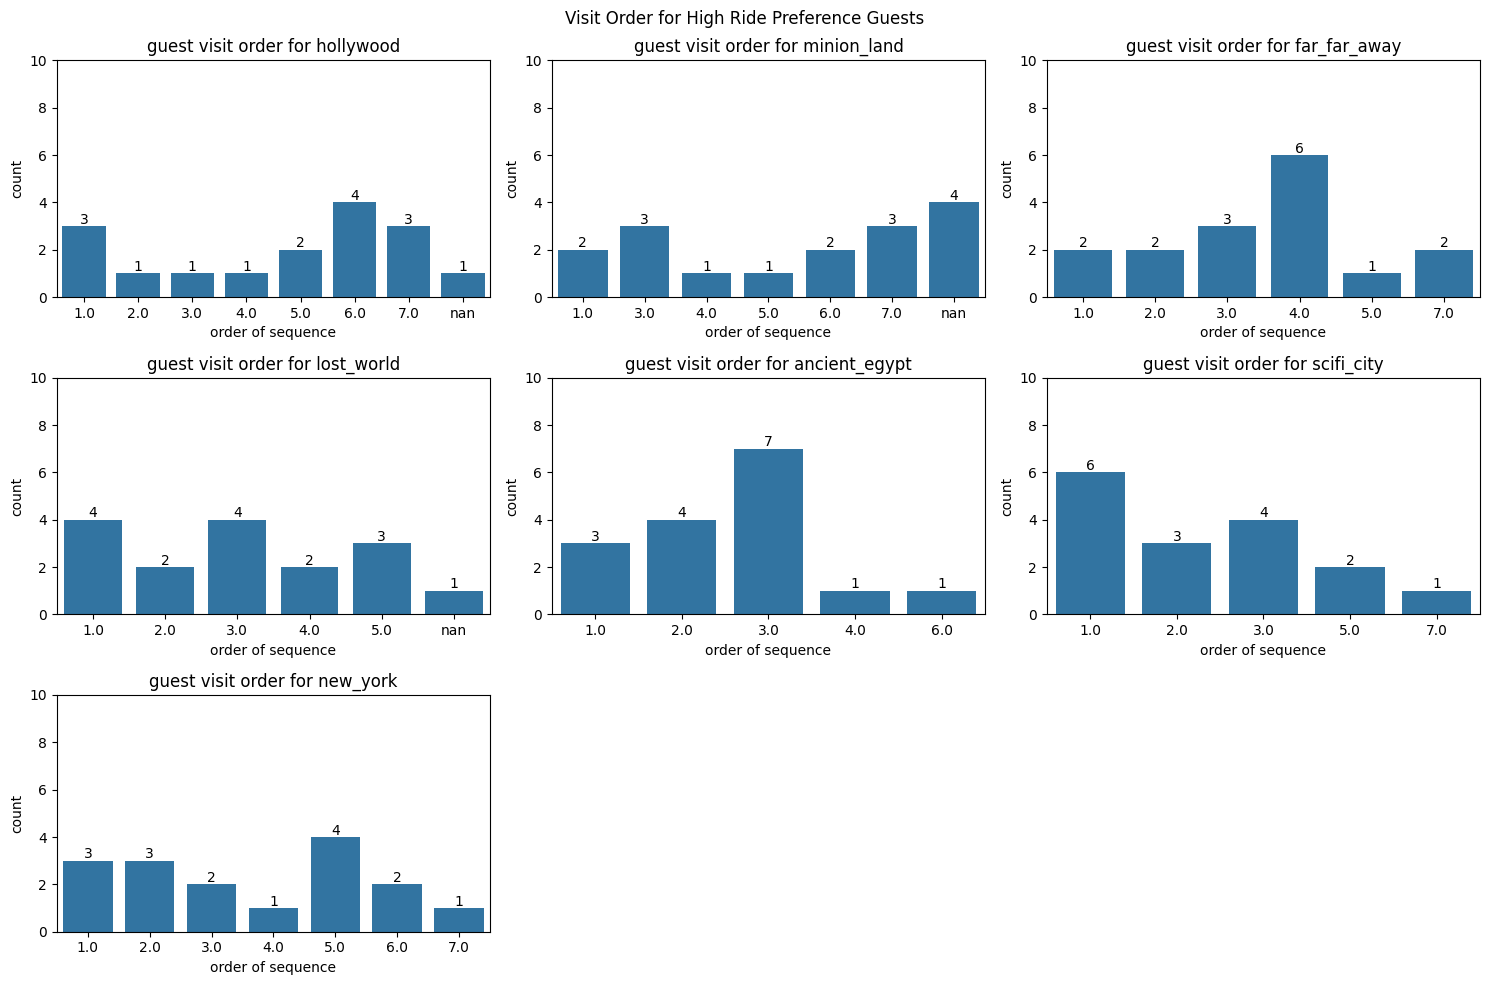

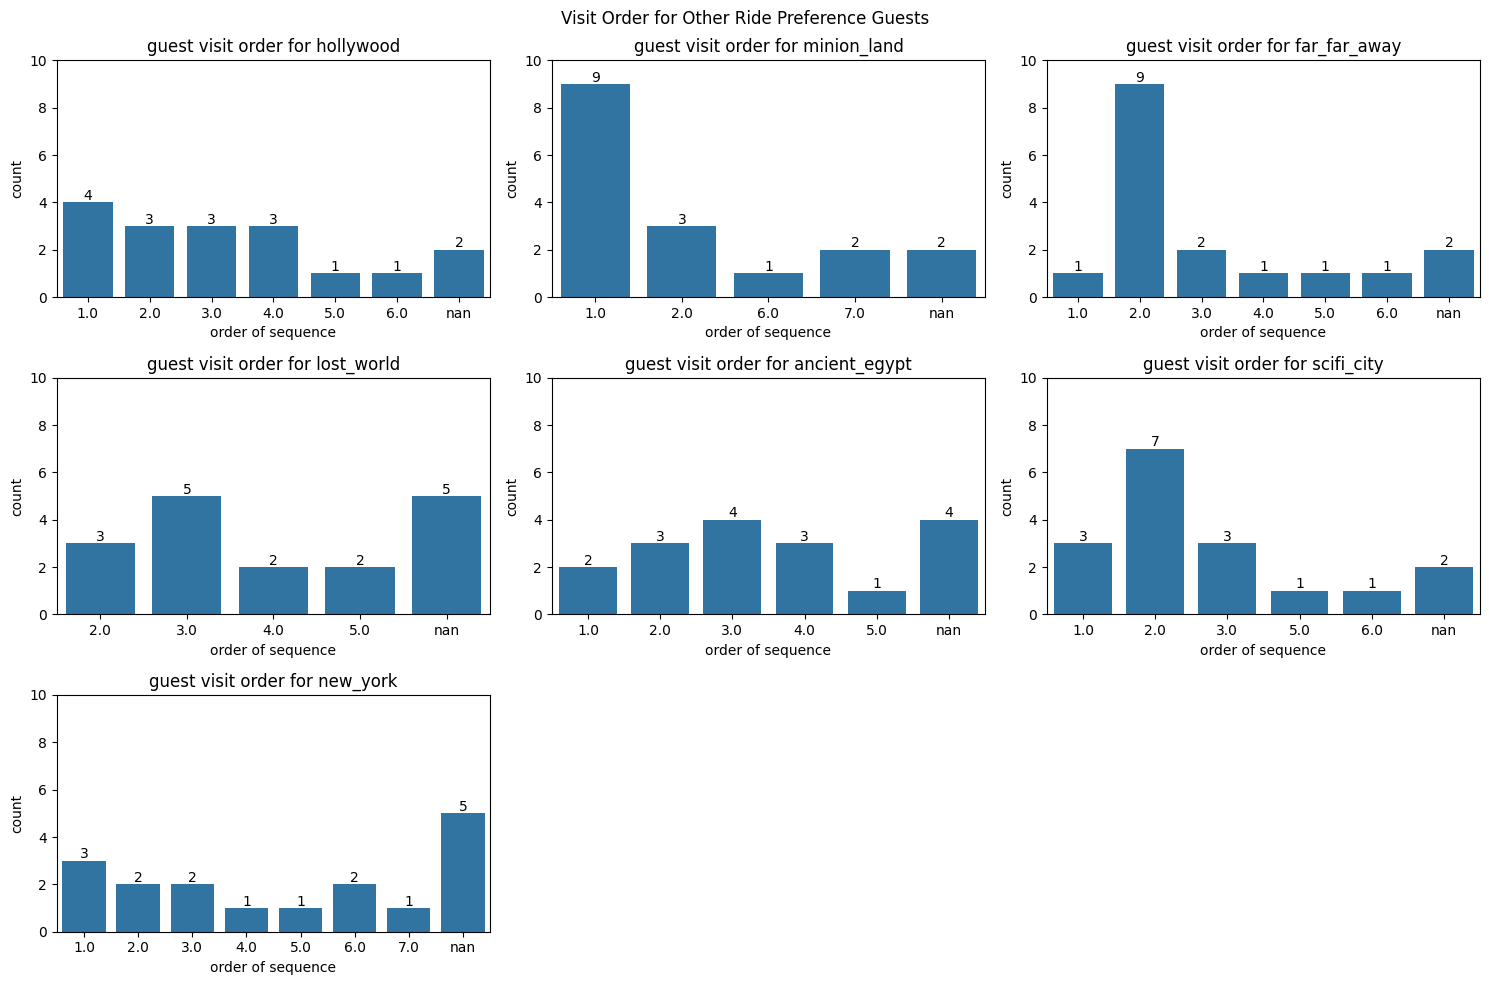

In [7]:
from guest_path_plot import plot_graph

plot_graph('High', high_guests)
plot_graph('Other', other_guests)

From these plots, we can make the following observations of the guests with different ride preferences:

**Guests with High Intensity Ride Preferences**
* These guests tend to start their day at Sci-Fi City, making it the most popular first zone to visit for this group. It can be noted from earlier analysis that Sci-Fi City is a high ride intensity zone.
* Ancient Egypt and Far Far Away tend to be the 3rd and 4th zones to visit respectively by this group of guests, which would be the middle of their day in USS.
* Hollywood and New York are usually the last few zones to be visited by this group of guests, possibly due to the close proximity of these zones to the exit point.
* We are unable to determine whether the high number of null values for Minion Land is due to this group's conscious choice to skip the zone, or whether responses were by those who visited USS before Minion Land had opened.

**Guests with Other Ride Intensity Preferences**
* Most of these guests start their day at Minion Land
* Far Far Away and Sci-Fi City are the most popular choices as the 2nd zone to visit by this group of guests
* A significant number of guests have The Lost World and Ancient Egypt as their 3rd destination of visit, which marks the middle of their day in USS.
* A significant number of this group of guests skipped New York and The Lost World. Due to insufficient data, it is not possible for us to explore the reasons of these guests for skipping the zones.

#### Analysing Guest Paths by Sequence Mining

The sequence mining uses the TNS algorithm from the SPMF library. Details of the library and the algorithm can be found in the `spmf` folder. The following analysis aims to find the top 7 sequential patterns observed by our survey respondants in how they navigate the zones in USS.

In [20]:
from sequence_mining import sequence_mining
high_seq = sequence_mining(high_guests['sequences'])
med_seq = sequence_mining(med_guests['sequences'])
low_seq = sequence_mining(low_guests['sequences'])
other_seq = sequence_mining(other_guests['sequences'])

>/C:/Users/Wan Sim/Documents/GitHub/DSA3101-Group5/guest_journey_path/spmf/spmf.jar
=============  TNS - STATS ========
Minsup : 10
Rules count: 7
Max candidates: 41
Sequential rules count: 7
-
Total time: 0.015 s
Max memory: 11.447906494140625
Rules eliminated by strategy 1: 9
Rules eliminated by strategy 2: 0
Post-processing to show result in terms of string values.
Post-processing completed.

>/C:/Users/Wan Sim/Documents/GitHub/DSA3101-Group5/guest_journey_path/spmf/spmf.jar
=============  TNS - STATS ========
Minsup : 7
Rules count: 7
Max candidates: 51
Sequential rules count: 7
-
Total time: 0.016 s
Max memory: 11.920127868652344
Rules eliminated by strategy 1: 34
Rules eliminated by strategy 2: 9
Post-processing to show result in terms of string values.
Post-processing completed.

>/C:/Users/Wan Sim/Documents/GitHub/DSA3101-Group5/guest_journey_path/spmf/spmf.jar
=============  TNS - STATS ========
Minsup : 2
Rules count: 7
Max candidates: 57
Sequential rules count: 7
-
Total tim

In [17]:
print(high_seq)

               visited_zone     next_zone  sup      conf
0             ancient_egypt  far_far_away   11  0.687500
1                lost_world      new_york   11  0.733333
2                scifi_city      new_york   12  0.750000
3                lost_world     hollywood   11  0.733333
4  lost_world,ancient_egypt     hollywood   10  0.666667
5             ancient_egypt      new_york   11  0.687500
6  lost_world,ancient_egypt      new_york   10  0.666667


In [18]:
print(med_seq)

                 visited_zone   next_zone  sup      conf
0                  scifi_city   hollywood    7  0.636364
1                far_far_away  scifi_city    7  0.700000
2                  lost_world    new_york    7  0.777778
3  far_far_away,ancient_egypt    new_york    7  0.777778
4               ancient_egypt    new_york    7  0.700000
5                far_far_away    new_york    7  0.700000
6                  scifi_city    new_york    7  0.636364


In [ ]:
print(low_seq)

                       visited_zone  \
0  hollywood,minion_land,scifi_city   
1                       minion_land   
2                       minion_land   
3                         hollywood   
4                      far_far_away   
5              hollywood,scifi_city   
6             hollywood,minion_land   

                                           next_zone  sup      conf  
0                           lost_world,ancient_egypt    2  1.000000  
1  far_far_away,lost_world,ancient_egypt,scifi_ci...    3  0.750000  
2                                       far_far_away    4  1.000000  
3                            far_far_away,scifi_city    3  0.750000  
4                lost_world,ancient_egypt,scifi_city    3  0.600000  
5                           lost_world,ancient_egypt    2  0.666667  
6   far_far_away,lost_world,ancient_egypt,scifi_city    2  0.666667  


The above outputs can be interpreted as follows:
* Should a guest vists the zones in `visited_zone`, they are likely to visit the zones in `next_zone` with a confidence of `conf`
* `sup` indicates the number of responses with this sequence observed in the data
* `conf` indicates the percentage of responses with the observed sequence out of the responses that have visited the zones in `visited_zone`

The following observations and remarks can also be made:
* Majority of guests with high ride intensity preferences will visit Ancient Egypt first before Far Far Away
* It is possible that most, if not all of the guests with low ride intensity preferences will visit Far Far Away after Minion Land. A confident conclusion cannot be made at this point due to the small response size.
* New York is a common point of visit across guests with high and medium ride intensity preferences. This is likely due to New York being one of the last few zones to visit for guests because of its proximity to the exit point.

WIth larger amounts of data, this method of sequence mining can be useful in creating predictive models for recommending methods of park navigation for guests with various types of interests as a form of personalisation for guest experience.


#### Overall Observations and Insights
From the above data analysis and sequence mining, it is shown that there are patterns in the way guests choose to navigate USS zones through their day based on their ride intensity preferences. This hence opens opportunities for USS to curate personalised experiences for groups of guests with similar interests.

With the tool of sequence mining and large enough data, USS can create recommended ways of navigating the park based on the common attractions a certain profile of guest would visit. This can be implemented as recommended itineraries for common interest profiles of guests, or as recommended alternative attractions for consideration when one views a specific attraction on the USS mobile app.


Another observation worth noting is the congregation of guests from all profiles in the zones around Ancient Egypt in the middle of their day in USS, which also corresponds with the common lunch hours. This correlates with the observation that the rides with the highest queue times mid-day are found in the zones around Ancient Egypt, indicating a surge in crowds in those zones. The large mass of visitors in the same area at the same time drives the biggest pain point of visitors of USS: long wait times for both rides and eateries.